In [12]:
# ============================================================================
# PHASE 2 - STEP 1: Data Loading
# ============================================================================

import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
from typing import Dict, List, Any, Optional
import glob

def parse_evaluation_filename(filename: str) -> Dict[str, str]:
    """
    Parse evaluation filename to extract configuration metadata.
    
    Filename format: evaluation_{mode}_{question_type}_{provider}_{model}_{temperature}_{template_alias}.json
    
    Args:
        filename: Evaluation filename (without path)
    
    Returns:
        Dictionary with parsed fields:
            - mode
            - question_type
            - provider
            - model
            - temperature
            - template_alias
    
    Example:
        >>> parse_evaluation_filename('evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json')
        {
            'mode': 'closed_book',
            'question_type': 'metrics-generated',
            'provider': 'openai',
            'model': 'gpt-4o-mini',
            'temperature': '0.0',
            'template_alias': 'metrics_closed_basic'
        }
    """
    # Remove 'evaluation_' prefix and '.json' suffix
    name = filename.replace('evaluation_', '').replace('.json', '')
    
    # Split by underscore
    parts = name.split('_')
    
    # Expected format: {mode}_{question_type}_{provider}_{model}_{temperature}_{template_alias}
    # But question_type has hyphen (e.g., 'metrics-generated')
    # And template_alias might have underscores (e.g., 'metrics_closed_basic')
    
    # Find question_type (contains hyphen)
    question_type_idx = None
    for i, part in enumerate(parts):
        if '-' in part:  # question_type contains hyphen
            question_type_idx = i
            break
    
    if question_type_idx is None:
        raise ValueError(f"Could not parse filename: {filename}. Question type not found.")
    
    # Parse components
    mode = '_'.join(parts[:question_type_idx])  # Everything before question_type
    question_type = parts[question_type_idx]
    provider = parts[question_type_idx + 1]
    model = parts[question_type_idx + 2]
    temperature = parts[question_type_idx + 3]
    template_alias = '_'.join(parts[question_type_idx + 4:])  # Rest is template_alias
    
    return {
        'mode': mode,
        'question_type': question_type,
        'provider': provider,
        'model': model,
        'temperature': temperature,
        'template_alias': template_alias
    }


def flatten_query_metrics(query_result: Dict[str, Any], question_type: str) -> Dict[str, Any]:
    """
    Flatten query evaluation results into a flat dictionary.
    
    Args:
        query_result: Single query result from evaluation JSON
        question_type: Question type for metric extraction
    
    Returns:
        Flat dictionary with all relevant fields
    
    Example:
        >>> query = {...}  # From evaluation JSON
        >>> flat = flatten_query_metrics(query, 'metrics-generated')
        >>> flat.keys()
        dict_keys(['financebench_id', 'question', 'gold_answer', 'generated_answer', 
                   'refusal_detected', 'nem_match', 'nem_relative_error', ...])
    """
    flat = {
        'financebench_id': query_result.get('financebench_id'),
        'question': query_result.get('question'),
        'gold_answer': query_result.get('gold_answer'),
        'generated_answer': query_result.get('generated_answer'),
        'question_type': query_result.get('question_type'),
    }
    
    # Extract refusal check
    refusal_check = query_result.get('evaluation', {}).get('refusal_check', {})
    flat['refusal_detected'] = refusal_check.get('is_refusal', None)
    flat['refusal_confidence'] = refusal_check.get('confidence', None)
    
    # Extract metrics based on question type
    metrics = query_result.get('evaluation', {}).get('metrics', {})
    
    if question_type == 'metrics-generated':
        # Numerical Exact Match (NEM)
        nem = metrics.get('numerical_exact_match', {})
        flat['nem_match'] = nem.get('match', None)
        flat['nem_gold_num'] = nem.get('gold_num', None)
        flat['nem_gen_num'] = nem.get('gen_num', None)
        flat['nem_relative_error'] = nem.get('relative_error', None)
        flat['nem_error_category'] = nem.get('error_category', None)
        
        # LLM as Judge Binary
        llm_binary = metrics.get('llm_as_judge_binary', {})
        flat['llm_binary_match'] = llm_binary.get('match', None)
        flat['llm_binary_gold_num'] = llm_binary.get('gold_num', None)
        flat['llm_binary_gen_num'] = llm_binary.get('gen_num', None)
        flat['llm_binary_relative_error'] = llm_binary.get('relative_error', None)
        flat['llm_binary_error_category'] = llm_binary.get('error_category', None)
        
    elif question_type == 'novel-generated':
        # Token F1
        token_f1 = metrics.get('token_f1', {})
        flat['token_f1'] = token_f1.get('f1', None)
        flat['token_precision'] = token_f1.get('precision', None)
        flat['token_recall'] = token_f1.get('recall', None)
        flat['token_gold_count'] = token_f1.get('gold_token_count', None)
        flat['token_gen_count'] = token_f1.get('gen_token_count', None)
        flat['token_common_count'] = token_f1.get('common_token_count', None)
        
        # LLM as Judge Graded
        llm_graded = metrics.get('llm_as_judge_graded', {})
        flat['llm_graded_score'] = llm_graded.get('score', None)
        flat['llm_graded_facts_present'] = len(llm_graded.get('facts_present', []))
        flat['llm_graded_facts_missing'] = len(llm_graded.get('facts_missing', []))
        
    elif question_type == 'domain-relevant':
        # LLM as Judge Graded
        llm_graded = metrics.get('llm_as_judge_graded', {})
        flat['llm_graded_score'] = llm_graded.get('score', None)
        flat['llm_graded_facts_present'] = len(llm_graded.get('facts_present', []))
        flat['llm_graded_facts_missing'] = len(llm_graded.get('facts_missing', []))
    
    return flat


def load_all_evaluations(evaluation_path: str, verbose: bool = True) -> pd.DataFrame:
    """
    Load all evaluation JSON files and convert to single DataFrame.
    
    Args:
        evaluation_path: Directory containing evaluation JSON files
        verbose: If True, print loading progress
    
    Returns:
        DataFrame with columns:
            Common columns:
            - financebench_id
            - mode (closed_book, rag, oracle)
            - question_type (metrics-generated, novel-generated, domain-relevant)
            - provider (openai, anthropic, etc.)
            - model (gpt-4o-mini, gpt-4o, etc.)
            - temperature
            - template_alias
            - question
            - gold_answer
            - generated_answer
            - refusal_detected
            - refusal_confidence
            
            Question-type-specific columns:
            For metrics-generated:
            - nem_match, nem_gold_num, nem_gen_num, nem_relative_error, nem_error_category
            - llm_binary_match, llm_binary_gold_num, llm_binary_gen_num, 
              llm_binary_relative_error, llm_binary_error_category
            
            For novel-generated:
            - token_f1, token_precision, token_recall
            - token_gold_count, token_gen_count, token_common_count
            - llm_graded_score, llm_graded_facts_present, llm_graded_facts_missing
            
            For domain-relevant:
            - llm_graded_score, llm_graded_facts_present, llm_graded_facts_missing
    
    Raises:
        FileNotFoundError: If evaluation_path doesn't exist
        ValueError: If no evaluation files found
    
    Example:
        >>> df = load_all_evaluations('../../evaluation_results/generation')
        >>> print(f"Loaded {len(df)} queries from {df['mode'].nunique()} modes")
        >>> print(df.columns.tolist())
        >>> print(df.groupby(['mode', 'question_type']).size())
    """
    # Validate path
    if not os.path.exists(evaluation_path):
        raise FileNotFoundError(f"Evaluation path not found: {evaluation_path}")
    
    # Find all evaluation JSON files
    pattern = os.path.join(evaluation_path, "evaluation_*.json")
    json_files = glob.glob(pattern)
    
    if not json_files:
        raise ValueError(f"No evaluation files found in: {evaluation_path}")
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"LOADING EVALUATION RESULTS")
        print(f"{'='*70}")
        print(f"\n📁 Path: {evaluation_path}")
        print(f"📊 Found {len(json_files)} evaluation files")
    
    # Load each file and collect rows
    all_rows = []
    
    for json_file in sorted(json_files):
        filename = os.path.basename(json_file)
        
        try:
            # Parse filename to get configuration
            config = parse_evaluation_filename(filename)
            
            if verbose:
                print(f"\n   Loading: {filename}")
                print(f"      Mode: {config['mode']}")
                print(f"      Question Type: {config['question_type']}")
                print(f"      Model: {config['provider']}/{config['model']}")
            
            # Read JSON file
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Get results
            results = data.get('results', [])
            
            if verbose:
                print(f"      Queries: {len(results)}")
            
            # Process each query
            for result in results:
                # Flatten query metrics
                flat_result = flatten_query_metrics(result, config['question_type'])
                
                # Add configuration metadata
                flat_result.update(config)
                
                all_rows.append(flat_result)
        
        except Exception as e:
            print(f"\n   ✗ Error loading {filename}: {str(e)}")
            raise
    
    # Convert to DataFrame
    df = pd.DataFrame(all_rows)
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"✅ LOADING COMPLETE")
        print(f"{'='*70}")
        print(f"\n📊 Summary:")
        print(f"   Total queries: {len(df)}")
        print(f"   Modes: {df['mode'].nunique()} ({', '.join(df['mode'].unique())})")
        print(f"   Question types: {df['question_type'].nunique()} ({', '.join(df['question_type'].unique())})")
        print(f"   Models: {df['model'].nunique()} ({', '.join(df['model'].unique())})")
        print(f"\n   Distribution:")
        distribution = df.groupby(['mode', 'question_type']).size()
        for (mode, qtype), count in distribution.items():
            print(f"      {mode:12s} | {qtype:20s}: {count:3d} queries")
        print(f"\n{'='*70}")
    
    return df


# ============================================================================
# STEP 1 Test Function
# ============================================================================

def test_step1():
    """Test Step 1: Data loading."""
    
    print("\n" + "="*70)
    print("PHASE 2 - STEP 1: DATA LOADING")
    print("="*70)
    
    # Test filename parsing
    print("\n🧪 Test 1: Filename Parsing")
    test_filename = "evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json"
    try:
        parsed = parse_evaluation_filename(test_filename)
        print(f"   Filename: {test_filename}")
        print(f"   Parsed:")
        for key, value in parsed.items():
            print(f"      {key}: {value}")
        print("   ✓ Parsing works")
    except Exception as e:
        print(f"   ✗ Parsing failed: {e}")
    
    # Test data loading
    print("\n🧪 Test 2: Load All Evaluations")
    print("\n⚠️  Please update EVALUATION_PATH before running this test")
    
    # You need to set this path
    EVALUATION_PATH = "../../evaluation_results/generation"  # UPDATE THIS
    
    try:
        df = load_all_evaluations(EVALUATION_PATH, verbose=True)
        
        print("\n📋 DataFrame Info:")
        print(f"   Shape: {df.shape} (rows × columns)")
        print(f"   Columns: {len(df.columns)}")
        print(f"\n   Column list:")
        for col in df.columns:
            print(f"      - {col}")
        
        print("\n📊 Sample Data (first 3 rows):")
        print(df.head(3)[['financebench_id', 'mode', 'question_type', 'model']].to_string())
        
        # Check for metrics-generated
        if 'metrics-generated' in df['question_type'].values:
            metrics_df = df[df['question_type'] == 'metrics-generated']
            print(f"\n   Metrics-generated columns:")
            metric_cols = [c for c in metrics_df.columns if 'nem_' in c or 'llm_binary_' in c]
            for col in metric_cols:
                print(f"      - {col}")
        
        # Check for novel-generated
        if 'novel-generated' in df['question_type'].values:
            novel_df = df[df['question_type'] == 'novel-generated']
            print(f"\n   Novel-generated columns:")
            metric_cols = [c for c in novel_df.columns if 'token_' in c or 'llm_graded_' in c]
            for col in metric_cols:
                print(f"      - {col}")
        
        # Check for domain-relevant
        if 'domain-relevant' in df['question_type'].values:
            domain_df = df[df['question_type'] == 'domain-relevant']
            print(f"\n   Domain-relevant columns:")
            metric_cols = [c for c in domain_df.columns if 'llm_graded_' in c]
            for col in metric_cols:
                print(f"      - {col}")
        
        print("\n" + "="*70)
        print("✅ Step 1 Complete!")
        print("="*70)
        print("\nStep 1 Functions Implemented:")
        print("  ✓ parse_evaluation_filename(filename)")
        print("  ✓ flatten_query_metrics(query_result, question_type)")
        print("  ✓ load_all_evaluations(evaluation_path)")
        print("\nFeatures:")
        print("  ✓ Parses evaluation filenames to extract config")
        print("  ✓ Flattens nested JSON structure")
        print("  ✓ Loads all evaluation files into single DataFrame")
        print("  ✓ Handles different question types")
        print("  ✓ Comprehensive progress reporting")
        print("\nNext: Step 2 - CSV Export")
        print("="*70)
        
        return df
        
    except FileNotFoundError as e:
        print(f"\n✗ Error: {e}")
        print("\n   Please:")
        print("   1. Update EVALUATION_PATH in test_step1()")
        print("   2. Ensure evaluation files exist in that directory")
        print("   3. Run test again")
    except Exception as e:
        print(f"\n✗ Error: {e}")
        raise


# To test:
if __name__ == "__main__":
    df = test_step1()
    # Returns DataFrame that you can inspect further


PHASE 2 - STEP 1: DATA LOADING

🧪 Test 1: Filename Parsing
   Filename: evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json
   Parsed:
      mode: closed_book
      question_type: metrics-generated
      provider: openai
      model: gpt-4o-mini
      temperature: 0.0
      template_alias: metrics_closed_basic
   ✓ Parsing works

🧪 Test 2: Load All Evaluations

⚠️  Please update EVALUATION_PATH before running this test

LOADING EVALUATION RESULTS

📁 Path: ../../evaluation_results/generation
📊 Found 8 evaluation files

   Loading: evaluation_closed_book_domain-relevant_openai_gpt-4o-mini_0.0_domain_closed_basic.json
      Mode: closed_book
      Question Type: domain-relevant
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading

In [13]:
# ============================================================================
# PHASE 2 - STEP 2: CSV Export Functions
# ============================================================================

def export_per_query_csv(
    df: pd.DataFrame,
    output_path: str,
    filters: Dict[str, Any] = None,
    truncate_text: bool = True,
    question_max_chars: int = 100,
    answer_max_chars: int = 50
):
    """
    Export detailed per-query results to CSV.
    
    Args:
        df: DataFrame from load_all_evaluations()
        output_path: Where to save CSV file
        filters: Optional filters (e.g., {'question_type': 'metrics-generated', 'mode': 'rag'})
        truncate_text: If True, truncate long text fields
        question_max_chars: Max characters for question column
        answer_max_chars: Max characters for answer columns
    
    Example:
        # Export all metrics-generated queries
        export_per_query_csv(
            df=df,
            output_path='analysis/csv/detail_metrics_generated.csv',
            filters={'question_type': 'metrics-generated'}
        )
        
        # Export all queries (no filter)
        export_per_query_csv(
            df=df,
            output_path='analysis/csv/detail_all_queries.csv'
        )
        
        # Export specific config
        export_per_query_csv(
            df=df,
            output_path='analysis/csv/detail_rag_novel.csv',
            filters={'question_type': 'novel-generated', 'mode': 'rag'}
        )
    """
    # Apply filters
    filtered_df = df.copy()
    
    if filters:
        print(f"\n📋 Applying filters:")
        for key, value in filters.items():
            if isinstance(value, list):
                filtered_df = filtered_df[filtered_df[key].isin(value)]
                print(f"   {key}: {', '.join(map(str, value))}")
            else:
                filtered_df = filtered_df[filtered_df[key] == value]
                print(f"   {key}: {value}")
        
        print(f"   Filtered: {len(df)} → {len(filtered_df)} queries")
    
    if len(filtered_df) == 0:
        print(f"⚠️  No data to export after filtering!")
        return
    
    # Prepare export DataFrame
    export_df = filtered_df.copy()
    
    # Truncate text fields if requested
    if truncate_text:
        if 'question' in export_df.columns:
            export_df['question'] = export_df['question'].apply(
                lambda x: x[:question_max_chars] + '...' if isinstance(x, str) and len(x) > question_max_chars else x
            )
        if 'gold_answer' in export_df.columns:
            export_df['gold_answer'] = export_df['gold_answer'].apply(
                lambda x: x[:answer_max_chars] + '...' if isinstance(x, str) and len(x) > answer_max_chars else x
            )
        if 'generated_answer' in export_df.columns:
            export_df['generated_answer'] = export_df['generated_answer'].apply(
                lambda x: x[:answer_max_chars] + '...' if isinstance(x, str) and len(x) > answer_max_chars else x
            )
    
    # Define column order (common columns first, then metrics)
    common_cols = [
        'financebench_id', 'mode', 'question_type', 'provider', 'model', 
        'temperature', 'template_alias', 'question', 'gold_answer', 
        'generated_answer', 'refusal_detected', 'refusal_confidence'
    ]
    
    # Get available common columns
    cols_to_export = [col for col in common_cols if col in export_df.columns]
    
    # Add remaining columns (metrics)
    remaining_cols = [col for col in export_df.columns if col not in cols_to_export]
    cols_to_export.extend(remaining_cols)
    
    # Reorder columns
    export_df = export_df[cols_to_export]
    
    # Create output directory if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Export to CSV
    export_df.to_csv(output_path, index=False, encoding='utf-8')
    
    # Get file size
    file_size_kb = os.path.getsize(output_path) / 1024
    
    print(f"\n💾 Exported per-query CSV:")
    print(f"   File: {output_path}")
    print(f"   Rows: {len(export_df)}")
    print(f"   Columns: {len(export_df.columns)}")
    print(f"   Size: {file_size_kb:.2f} KB")


def aggregate_metrics(df: pd.DataFrame, group_by: List[str]) -> pd.DataFrame:
    """
    Aggregate metrics by specified grouping columns.
    
    Args:
        df: DataFrame from load_all_evaluations()
        group_by: Columns to group by
    
    Returns:
        DataFrame with aggregated metrics
    
    Note: Different aggregations are computed based on question_type
    """
    aggregated_rows = []
    
    # Group by specified columns
    for group_keys, group_df in df.groupby(group_by):
        # Convert single key to tuple for consistency
        if not isinstance(group_keys, tuple):
            group_keys = (group_keys,)
        
        # Create base row with group keys
        row = dict(zip(group_by, group_keys))
        
        # Get question type for this group
        question_type = group_df['question_type'].iloc[0]
        
        # Common metrics
        row['total_queries'] = len(group_df)
        row['refusal_rate'] = group_df['refusal_detected'].mean() if 'refusal_detected' in group_df.columns else None
        
        # Question-type-specific metrics
        if question_type == 'metrics-generated':
            # NEM metrics
            if 'nem_match' in group_df.columns:
                row['nem_accuracy'] = group_df['nem_match'].mean() * 100  # Convert to percentage
                row['nem_mean_relative_error'] = group_df['nem_relative_error'].mean()
                row['nem_median_relative_error'] = group_df['nem_relative_error'].median()
            
            # LLM binary metrics
            if 'llm_binary_match' in group_df.columns:
                row['llm_binary_accuracy'] = group_df['llm_binary_match'].mean() * 100
                row['llm_binary_mean_relative_error'] = group_df['llm_binary_relative_error'].mean()
                row['llm_binary_median_relative_error'] = group_df['llm_binary_relative_error'].median()
            
            # Agreement between NEM and LLM
            if 'nem_match' in group_df.columns and 'llm_binary_match' in group_df.columns:
                agreement = (group_df['nem_match'] == group_df['llm_binary_match']).mean() * 100
                row['nem_llm_agreement_rate'] = agreement
        
        elif question_type == 'novel-generated':
            # Token F1 metrics
            if 'token_f1' in group_df.columns:
                row['mean_token_f1'] = group_df['token_f1'].mean()
                row['median_token_f1'] = group_df['token_f1'].median()
                row['std_token_f1'] = group_df['token_f1'].std()
                row['min_token_f1'] = group_df['token_f1'].min()
                row['max_token_f1'] = group_df['token_f1'].max()
            
            if 'token_precision' in group_df.columns:
                row['mean_token_precision'] = group_df['token_precision'].mean()
            
            if 'token_recall' in group_df.columns:
                row['mean_token_recall'] = group_df['token_recall'].mean()
            
            # LLM graded metrics
            if 'llm_graded_score' in group_df.columns:
                row['mean_llm_graded_score'] = group_df['llm_graded_score'].mean()
                row['median_llm_graded_score'] = group_df['llm_graded_score'].median()
                row['std_llm_graded_score'] = group_df['llm_graded_score'].std()
                
                # Score distribution
                for score in range(5):  # 0-4
                    count = (group_df['llm_graded_score'] == score).sum()
                    row[f'llm_score_{score}_count'] = count
                    row[f'llm_score_{score}_pct'] = (count / len(group_df)) * 100
        
        elif question_type == 'domain-relevant':
            # LLM graded metrics
            if 'llm_graded_score' in group_df.columns:
                row['mean_llm_graded_score'] = group_df['llm_graded_score'].mean()
                row['median_llm_graded_score'] = group_df['llm_graded_score'].median()
                row['std_llm_graded_score'] = group_df['llm_graded_score'].std()
                row['min_llm_graded_score'] = group_df['llm_graded_score'].min()
                row['max_llm_graded_score'] = group_df['llm_graded_score'].max()
                
                # Score distribution
                for score in range(5):  # 0-4
                    count = (group_df['llm_graded_score'] == score).sum()
                    row[f'llm_score_{score}_count'] = count
                    row[f'llm_score_{score}_pct'] = (count / len(group_df)) * 100
        
        aggregated_rows.append(row)
    
    return pd.DataFrame(aggregated_rows)


def export_summary_csv(
    df: pd.DataFrame,
    output_path: str,
    group_by: List[str] = ['mode', 'question_type', 'provider', 'model', 'template_alias']
):
    """
    Export aggregated summary statistics to CSV.
    
    Args:
        df: DataFrame from load_all_evaluations()
        output_path: Where to save CSV file
        group_by: Columns to group by for aggregation
    
    Example:
        # Summary by full configuration
        export_summary_csv(
            df=df,
            output_path='analysis/csv/summary_by_config.csv',
            group_by=['mode', 'question_type', 'provider', 'model', 'template_alias']
        )
        
        # Summary by mode and question type only
        export_summary_csv(
            df=df,
            output_path='analysis/csv/summary_by_mode.csv',
            group_by=['mode', 'question_type']
        )
        
        # Summary by question type only (across all modes)
        export_summary_csv(
            df=df,
            output_path='analysis/csv/summary_by_question_type.csv',
            group_by=['question_type']
        )
    """
    print(f"\n📊 Aggregating metrics...")
    print(f"   Group by: {', '.join(group_by)}")
    
    # Aggregate metrics
    summary_df = aggregate_metrics(df, group_by)
    
    print(f"   Groups: {len(summary_df)}")
    
    # Create output directory if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Export to CSV
    summary_df.to_csv(output_path, index=False, encoding='utf-8')
    
    # Get file size
    file_size_kb = os.path.getsize(output_path) / 1024
    
    print(f"\n💾 Exported summary CSV:")
    print(f"   File: {output_path}")
    print(f"   Rows: {len(summary_df)}")
    print(f"   Columns: {len(summary_df.columns)}")
    print(f"   Size: {file_size_kb:.2f} KB")
    
    # Show sample of summary
    if len(summary_df) > 0:
        print(f"\n   Sample (first 3 rows):")
        display_cols = group_by + ['total_queries', 'refusal_rate']
        display_cols = [col for col in display_cols if col in summary_df.columns]
        print(summary_df.head(3)[display_cols].to_string(index=False))


# ============================================================================
# STEP 2 Test Function
# ============================================================================

def test_step2(df: pd.DataFrame):
    """
    Test Step 2: CSV export functions.
    
    Args:
        df: DataFrame from load_all_evaluations() (from Step 1)
    """
    print("\n" + "="*70)
    print("PHASE 2 - STEP 2: CSV EXPORT")
    print("="*70)
    
    # Create output directory
    output_dir = "../../evaluation_results/generation/analysis/csv"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n📁 Output directory: {output_dir}")
    
    # Test 1: Export per-query CSVs by question type
    print("\n🧪 Test 1: Export Per-Query CSVs by Question Type")
    
    for qtype in df['question_type'].unique():
        output_path = f"{output_dir}/detail_{qtype.replace('-', '_')}.csv"
        export_per_query_csv(
            df=df,
            output_path=output_path,
            filters={'question_type': qtype}
        )
    
    # Test 2: Export full detail CSV (all queries)
    print("\n🧪 Test 2: Export Full Detail CSV")
    export_per_query_csv(
        df=df,
        output_path=f"{output_dir}/detail_all_queries.csv"
    )
    
    # Test 3: Export summary by full configuration
    print("\n🧪 Test 3: Export Summary by Configuration")
    export_summary_csv(
        df=df,
        output_path=f"{output_dir}/summary_by_config.csv",
        group_by=['mode', 'question_type', 'provider', 'model', 'template_alias']
    )
    
    # Test 4: Export summary by mode and question type
    print("\n🧪 Test 4: Export Summary by Mode")
    export_summary_csv(
        df=df,
        output_path=f"{output_dir}/summary_by_mode.csv",
        group_by=['mode', 'question_type']
    )
    
    # Test 5: Export summary by question type only
    print("\n🧪 Test 5: Export Summary by Question Type")
    export_summary_csv(
        df=df,
        output_path=f"{output_dir}/summary_by_question_type.csv",
        group_by=['question_type']
    )
    
    # List all generated files
    print("\n" + "="*70)
    print("📋 Generated CSV Files:")
    print("="*70)
    
    csv_files = sorted(glob.glob(f"{output_dir}/*.csv"))
    for csv_file in csv_files:
        file_size_kb = os.path.getsize(csv_file) / 1024
        filename = os.path.basename(csv_file)
        print(f"   {filename:50s} ({file_size_kb:6.2f} KB)")
    
    print("\n" + "="*70)
    print("✅ Step 2 Complete!")
    print("="*70)
    print("\nStep 2 Functions Implemented:")
    print("  ✓ export_per_query_csv(df, output_path, filters)")
    print("  ✓ aggregate_metrics(df, group_by)")
    print("  ✓ export_summary_csv(df, output_path, group_by)")
    print("\nFeatures:")
    print("  ✓ Export detailed per-query results")
    print("  ✓ Filter by any column(s)")
    print("  ✓ Truncate long text fields")
    print("  ✓ Aggregate metrics by any grouping")
    print("  ✓ Question-type-specific aggregations")
    print("  ✓ Multiple summary levels (config, mode, question_type)")
    print("\nCSV Files Generated:")
    print(f"  ✓ {len(csv_files)} files in {output_dir}/")
    print("\nNext: Step 3 - Plot 1 (Performance by Mode)")
    print("="*70)


# To test:
if __name__ == "__main__":
    # Load data from Step 1
    df = load_all_evaluations("../../evaluation_results/generation")
    
    # Run Step 2 tests
    test_step2(df)


LOADING EVALUATION RESULTS

📁 Path: ../../evaluation_results/generation
📊 Found 8 evaluation files

   Loading: evaluation_closed_book_domain-relevant_openai_gpt-4o-mini_0.0_domain_closed_basic.json
      Mode: closed_book
      Question Type: domain-relevant
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o
      Queries: 50

   Loading: evaluation_closed_book_novel-generated_openai_gpt-4o-mini_0.0_novel_closed_basic.json
      Mode: closed_book
      Question Type: novel-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_oracle_domain-relevant_openai_gpt

In [14]:
# ============================================================================
# PHASE 2 - STEP 3: Plot 1 - Performance by Mode
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Color schemes
MODE_COLORS = {
    'closed_book': '#E74C3C',  # Red
    'rag': '#3498DB',           # Blue  
    'oracle': '#2ECC71'         # Green
}

MODEL_COLORS = {
    'gpt-4o-mini': '#9B59B6',   # Purple
    'gpt-4o': '#F39C12',        # Orange
    'claude-sonnet-4': '#1ABC9C',  # Teal
    'claude-opus-4': '#E67E22'     # Dark Orange
}

# Font settings for publication quality
PLOT_FONT_CONFIG = {
    'font.family': 'serif',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
}


def filter_dataframe(
    df: pd.DataFrame,
    question_type: str = None,
    modes: List[str] = None,
    providers: List[str] = None,
    models: List[str] = None,
    template_aliases: List[str] = None
) -> pd.DataFrame:
    """
    Filter DataFrame based on provided criteria.
    
    Args:
        df: Full DataFrame
        question_type: Single question type to filter
        modes: List of modes to include
        providers: List of providers to include
        models: List of models to include
        template_aliases: List of template aliases to include
    
    Returns:
        Filtered DataFrame
    """
    filtered = df.copy()
    
    if question_type:
        filtered = filtered[filtered['question_type'] == question_type]
    
    if modes:
        filtered = filtered[filtered['mode'].isin(modes)]
    
    if providers:
        filtered = filtered[filtered['provider'].isin(providers)]
    
    if models:
        filtered = filtered[filtered['model'].isin(models)]
    
    if template_aliases:
        filtered = filtered[filtered['template_alias'].isin(template_aliases)]
    
    return filtered


def compute_metric_aggregation(
    df: pd.DataFrame,
    metric: str,
    question_type: str
) -> pd.DataFrame:
    """
    Compute aggregated metric values grouped by mode and model.
    
    Args:
        df: Filtered DataFrame
        metric: Metric to compute
        question_type: Question type for metric validation
    
    Returns:
        DataFrame with columns: mode, model, metric_mean, metric_std
    """
    # Validate metric for question type
    valid_metrics = {
        'metrics-generated': ['nem_accuracy', 'llm_binary_accuracy', 'nem_mean_relative_error', 
                             'llm_binary_mean_relative_error', 'nem_llm_agreement_rate'],
        'novel-generated': ['token_f1', 'token_precision', 'token_recall', 'llm_graded_score'],
        'domain-relevant': ['llm_graded_score']
    }
    
    if question_type not in valid_metrics:
        raise ValueError(f"Unknown question type: {question_type}")
    
    if metric not in valid_metrics[question_type]:
        raise ValueError(
            f"Metric '{metric}' not valid for question type '{question_type}'. "
            f"Valid metrics: {', '.join(valid_metrics[question_type])}"
        )
    
    # Map metric to actual column name
    metric_col_map = {
        'nem_accuracy': 'nem_match',
        'llm_binary_accuracy': 'llm_binary_match',
        'token_f1': 'token_f1',
        'token_precision': 'token_precision',
        'token_recall': 'token_recall',
        'llm_graded_score': 'llm_graded_score',
        'nem_mean_relative_error': 'nem_relative_error',
        'llm_binary_mean_relative_error': 'llm_binary_relative_error',
        'nem_llm_agreement_rate': None  # Special case - computed later
    }
    
    # Special handling for accuracy metrics (convert boolean to percentage)
    if metric in ['nem_accuracy', 'llm_binary_accuracy']:
        metric_col = metric_col_map[metric]
        grouped = df.groupby(['mode', 'model'])[metric_col].agg(['mean', 'std']).reset_index()
        grouped['mean'] = grouped['mean'] * 100  # Convert to percentage
        grouped['std'] = grouped['std'] * 100
    
    # Special handling for agreement rate
    elif metric == 'nem_llm_agreement_rate':
        # Compute agreement between nem_match and llm_binary_match
        df['agreement'] = (df['nem_match'] == df['llm_binary_match']).astype(int)
        grouped = df.groupby(['mode', 'model'])['agreement'].agg(['mean', 'std']).reset_index()
        grouped['mean'] = grouped['mean'] * 100  # Convert to percentage
        grouped['std'] = grouped['std'] * 100
    
    # Standard metrics
    else:
        metric_col = metric_col_map[metric]
        grouped = df.groupby(['mode', 'model'])[metric_col].agg(['mean', 'std']).reset_index()
    
    # Rename columns
    grouped.columns = ['mode', 'model', 'metric_mean', 'metric_std']
    
    return grouped


def plot_performance_by_mode(
    df: pd.DataFrame,
    question_type: str,
    metric: str,
    modes: List[str] = ['closed_book', 'rag', 'oracle'],
    providers: List[str] = None,
    models: List[str] = None,
    template_aliases: List[str] = None,
    output_path: str = None,
    title: str = None,
    ylabel: str = None,
    figsize: Tuple[int, int] = (10, 6),
    dpi: int = 300,
    show_values: bool = True,
    show_std: bool = True
):
    """
    Plot performance metric by mode for a specific question type.
    
    Args:
        df: Full DataFrame from load_all_evaluations()
        question_type: 'metrics-generated', 'novel-generated', or 'domain-relevant'
        metric: Metric to plot
            For metrics-generated: 'nem_accuracy', 'llm_binary_accuracy', 
                                   'nem_mean_relative_error', 'llm_binary_mean_relative_error',
                                   'nem_llm_agreement_rate'
            For novel-generated: 'token_f1', 'token_precision', 'token_recall', 'llm_graded_score'
            For domain-relevant: 'llm_graded_score'
        modes: List of modes to include (default: all 3)
        providers: Filter by providers (e.g., ['openai'])
        models: Filter by models (e.g., ['gpt-4o-mini', 'gpt-4o'])
        template_aliases: Filter by templates
        output_path: Where to save plot (if None, just show)
        title: Custom title (if None, auto-generate)
        ylabel: Custom y-axis label (if None, auto-generate)
        figsize: Figure size in inches
        dpi: Resolution
        show_values: If True, show values on top of bars
        show_std: If True, show error bars (standard deviation)
    
    Returns:
        matplotlib Figure object
    
    Example:
        # Compare gpt-4o-mini vs gpt-4o for metrics-generated on NEM accuracy
        plot_performance_by_mode(
            df=df,
            question_type='metrics-generated',
            metric='nem_accuracy',
            models=['gpt-4o-mini', 'gpt-4o'],
            output_path='analysis/plots/nem_accuracy_model_comparison.png'
        )
        
        # Plot token F1 for novel-generated with single model
        plot_performance_by_mode(
            df=df,
            question_type='novel-generated',
            metric='token_f1',
            models=['gpt-4o-mini'],
            output_path='analysis/plots/token_f1_by_mode.png'
        )
    """
    # Apply plot font configuration
    plt.rcParams.update(PLOT_FONT_CONFIG)
    
    # Filter data
    filtered_df = filter_dataframe(
        df=df,
        question_type=question_type,
        modes=modes,
        providers=providers,
        models=models,
        template_aliases=template_aliases
    )
    
    if len(filtered_df) == 0:
        print("⚠️  No data after filtering. Cannot create plot.")
        return None
    
    print(f"\n📊 Creating plot...")
    print(f"   Question type: {question_type}")
    print(f"   Metric: {metric}")
    print(f"   Data points: {len(filtered_df)}")
    print(f"   Modes: {filtered_df['mode'].unique().tolist()}")
    print(f"   Models: {filtered_df['model'].unique().tolist()}")
    
    # Compute aggregated metrics
    agg_df = compute_metric_aggregation(filtered_df, metric, question_type)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique modes and models
    unique_modes = [m for m in modes if m in agg_df['mode'].values]
    unique_models = agg_df['model'].unique().tolist()
    
    # Set up bar positions
    n_modes = len(unique_modes)
    n_models = len(unique_models)
    bar_width = 0.8 / n_models if n_models > 1 else 0.6
    x = np.arange(n_modes)
    
    # Plot bars for each model
    for i, model in enumerate(unique_models):
        model_data = agg_df[agg_df['model'] == model]
        
        # Get values for each mode (in correct order)
        values = []
        errors = []
        for mode in unique_modes:
            mode_data = model_data[model_data['mode'] == mode]
            if len(mode_data) > 0:
                values.append(mode_data['metric_mean'].iloc[0])
                errors.append(mode_data['metric_std'].iloc[0] if show_std else 0)
            else:
                values.append(0)
                errors.append(0)
        
        # Calculate bar positions
        if n_models > 1:
            positions = x + (i - n_models/2 + 0.5) * bar_width
        else:
            positions = x
        
        # Choose color
        color = MODEL_COLORS.get(model, f'C{i}')
        
        # Plot bars
        bars = ax.bar(
            positions,
            values,
            bar_width,
            label=model,
            color=color,
            alpha=0.8,
            yerr=errors if show_std else None,
            capsize=5,
            error_kw={'linewidth': 1.5, 'ecolor': 'gray'}
        )
        
        # Add value labels on bars
        if show_values:
            for bar, value in zip(bars, values):
                height = bar.get_height()
                if height > 0:  # Only show non-zero values
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        height,
                        f'{value:.1f}',
                        ha='center',
                        va='bottom',
                        fontsize=9,
                        fontweight='bold'
                    )
    
    # Customize plot
    ax.set_xlabel('Mode', fontweight='bold')
    
    # Auto-generate y-axis label if not provided
    if ylabel is None:
        if 'accuracy' in metric or 'agreement' in metric:
            ylabel = 'Accuracy (%)'
        elif 'error' in metric:
            ylabel = 'Mean Relative Error (%)'
        elif metric == 'token_f1':
            ylabel = 'Token F1 Score'
        elif metric in ['token_precision', 'token_recall']:
            ylabel = metric.replace('token_', '').capitalize()
        elif metric == 'llm_graded_score':
            ylabel = 'LLM Score (0-4)'
        else:
            ylabel = metric.replace('_', ' ').title()
    
    ax.set_ylabel(ylabel, fontweight='bold')
    
    # Auto-generate title if not provided
    if title is None:
        metric_display = metric.replace('_', ' ').title()
        qtype_display = question_type.replace('-', ' ').title()
        title = f'{metric_display} - {qtype_display}'
    
    ax.set_title(title, fontweight='bold', pad=20)
    
    # Set x-axis ticks
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in unique_modes])
    
    # Set y-axis limits
    if 'accuracy' in metric or 'agreement' in metric or 'f1' in metric:
        ax.set_ylim(0, 105)  # 0-100% with some headroom
    elif 'score' in metric and question_type in ['novel-generated', 'domain-relevant']:
        ax.set_ylim(0, 4.5)  # 0-4 scale with headroom
    
    # Add grid
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add legend if multiple models
    if n_models > 1:
        ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        # Create directory if needed
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Save figure
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
        
        # Get file size
        file_size_kb = os.path.getsize(output_path) / 1024
        
        print(f"\n💾 Saved plot:")
        print(f"   File: {output_path}")
        print(f"   Size: {file_size_kb:.2f} KB")
        print(f"   DPI: {dpi}")
    
    return fig


# ============================================================================
# STEP 3 Test Function
# ============================================================================

def test_step3(df: pd.DataFrame):
    """
    Test Step 3: Plot performance by mode.
    
    Args:
        df: DataFrame from load_all_evaluations() (from Step 1)
    """
    print("\n" + "="*70)
    print("PHASE 2 - STEP 3: PLOT 1 - PERFORMANCE BY MODE")
    print("="*70)
    
    # Create output directory
    output_dir = "../../evaluation_results/generation/analysis/plots"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n📁 Output directory: {output_dir}")
    
    # Get unique models in dataset
    unique_models = df['model'].unique().tolist()
    print(f"\n📋 Models in dataset: {', '.join(unique_models)}")
    
    # Test 1: Metrics-generated - NEM accuracy (single model)
    print("\n🧪 Test 1: Metrics-Generated - NEM Accuracy")
    fig1 = plot_performance_by_mode(
        df=df,
        question_type='metrics-generated',
        metric='nem_accuracy',
        models=[unique_models[0]],  # First model only
        output_path=f'{output_dir}/metrics_nem_accuracy.png'
    )
    if fig1:
        plt.close(fig1)
    
    # Test 2: Metrics-generated - LLM binary accuracy (single model)
    print("\n🧪 Test 2: Metrics-Generated - LLM Binary Accuracy")
    fig2 = plot_performance_by_mode(
        df=df,
        question_type='metrics-generated',
        metric='llm_binary_accuracy',
        models=[unique_models[0]],
        output_path=f'{output_dir}/metrics_llm_binary_accuracy.png'
    )
    if fig2:
        plt.close(fig2)
    
    # Test 3: Novel-generated - Token F1
    print("\n🧪 Test 3: Novel-Generated - Token F1")
    fig3 = plot_performance_by_mode(
        df=df,
        question_type='novel-generated',
        metric='token_f1',
        models=[unique_models[0]],
        output_path=f'{output_dir}/novel_token_f1.png'
    )
    if fig3:
        plt.close(fig3)
    
    # Test 4: Novel-generated - LLM graded score
    print("\n🧪 Test 4: Novel-Generated - LLM Graded Score")
    fig4 = plot_performance_by_mode(
        df=df,
        question_type='novel-generated',
        metric='llm_graded_score',
        models=[unique_models[0]],
        output_path=f'{output_dir}/novel_llm_score.png'
    )
    if fig4:
        plt.close(fig4)
    
    # Test 5: Domain-relevant - LLM graded score
    print("\n🧪 Test 5: Domain-Relevant - LLM Graded Score")
    fig5 = plot_performance_by_mode(
        df=df,
        question_type='domain-relevant',
        metric='llm_graded_score',
        models=[unique_models[0]],
        output_path=f'{output_dir}/domain_llm_score.png'
    )
    if fig5:
        plt.close(fig5)
    
    # Test 6: Multi-model comparison (if multiple models exist)
    if len(unique_models) > 1:
        print("\n🧪 Test 6: Multi-Model Comparison - NEM Accuracy")
        fig6 = plot_performance_by_mode(
            df=df,
            question_type='metrics-generated',
            metric='nem_accuracy',
            models=unique_models[:2],  # First two models
            output_path=f'{output_dir}/metrics_nem_accuracy_model_comparison.png'
        )
        if fig6:
            plt.close(fig6)
    
    # List all generated plots
    print("\n" + "="*70)
    print("📋 Generated Plot Files:")
    print("="*70)
    
    plot_files = sorted(glob.glob(f"{output_dir}/*.png"))
    for plot_file in plot_files:
        file_size_kb = os.path.getsize(plot_file) / 1024
        filename = os.path.basename(plot_file)
        print(f"   {filename:50s} ({file_size_kb:6.2f} KB)")
    
    print("\n" + "="*70)
    print("✅ Step 3 Complete!")
    print("="*70)
    print("\nStep 3 Functions Implemented:")
    print("  ✓ filter_dataframe(df, question_type, modes, providers, models, template_aliases)")
    print("  ✓ compute_metric_aggregation(df, metric, question_type)")
    print("  ✓ plot_performance_by_mode(df, question_type, metric, ...)")
    print("\nFeatures:")
    print("  ✓ Flexible filtering by any combination of parameters")
    print("  ✓ Support for multiple models comparison")
    print("  ✓ Question-type-specific metrics")
    print("  ✓ Auto-generated titles and labels")
    print("  ✓ Error bars (standard deviation)")
    print("  ✓ Value labels on bars")
    print("  ✓ Publication-quality styling")
    print("\nPlot Files Generated:")
    print(f"  ✓ {len(plot_files)} plots in {output_dir}/")
    print("\nNext: Step 4 - Plot 2 (Metric Comparison)")
    print("="*70)


# To test:
if __name__ == "__main__":
    # Load data from Step 1
    df = load_all_evaluations("../../evaluation_results/generation")
    
    # Run Step 3 tests
    test_step3(df)


LOADING EVALUATION RESULTS

📁 Path: ../../evaluation_results/generation
📊 Found 8 evaluation files

   Loading: evaluation_closed_book_domain-relevant_openai_gpt-4o-mini_0.0_domain_closed_basic.json
      Mode: closed_book
      Question Type: domain-relevant
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o
      Queries: 50

   Loading: evaluation_closed_book_novel-generated_openai_gpt-4o-mini_0.0_novel_closed_basic.json
      Mode: closed_book
      Question Type: novel-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_oracle_domain-relevant_openai_gpt

In [ ]:
# ============================================================================
# PHASE 2 - STEP 4: Plot 2 - Metric Comparison
# ============================================================================

def plot_metric_comparison_numerical(
    df: pd.DataFrame,
    metrics: List[str] = ['nem_accuracy', 'llm_binary_accuracy'],
    modes: List[str] = ['closed_book', 'rag', 'oracle'],
    providers: List[str] = None,
    models: List[str] = None,
    template_aliases: List[str] = None,
    output_path: str = None,
    title: str = None,
    ylabel: str = None,
    figsize: Tuple[int, int] = (10, 6),
    dpi: int = 300,
    show_values: bool = True,
    show_std: bool = True
):
    """
    Compare multiple metrics for metrics-generated questions.
    
    Args:
        df: Full DataFrame from load_all_evaluations()
        metrics: List of metrics to compare (e.g., ['nem_accuracy', 'llm_binary_accuracy'])
                 Valid metrics for metrics-generated:
                 - 'nem_accuracy'
                 - 'llm_binary_accuracy'
                 - 'nem_mean_relative_error'
                 - 'llm_binary_mean_relative_error'
                 - 'nem_llm_agreement_rate'
        modes: List of modes to include
        providers: Filter by providers
        models: Filter by models (typically single model for clarity)
        template_aliases: Filter by templates
        output_path: Where to save plot
        title: Custom title
        ylabel: Custom y-axis label
        figsize: Figure size in inches
        dpi: Resolution
        show_values: If True, show values on top of bars
        show_std: If True, show error bars
    
    Returns:
        matplotlib Figure object
    
    Example:
        # Compare NEM vs LLM-binary for gpt-4o-mini
        plot_metric_comparison_numerical(
            df=df,
            metrics=['nem_accuracy', 'llm_binary_accuracy'],
            models=['gpt-4o-mini'],
            output_path='analysis/plots/nem_vs_llm_comparison.png'
        )
        
        # Compare error rates
        plot_metric_comparison_numerical(
            df=df,
            metrics=['nem_mean_relative_error', 'llm_binary_mean_relative_error'],
            models=['gpt-4o-mini'],
            output_path='analysis/plots/error_comparison.png'
        )
        
        # Compare multiple models on NEM accuracy
        plot_metric_comparison_numerical(
            df=df,
            metrics=['nem_accuracy'],
            models=['gpt-4o-mini', 'gpt-4o'],
            output_path='analysis/plots/nem_model_comparison.png'
        )
    """
    # Apply plot font configuration
    plt.rcParams.update(PLOT_FONT_CONFIG)
    
    # Filter data to metrics-generated only
    filtered_df = filter_dataframe(
        df=df,
        question_type='metrics-generated',
        modes=modes,
        providers=providers,
        models=models,
        template_aliases=template_aliases
    )
    
    if len(filtered_df) == 0:
        print("⚠️  No data after filtering. Cannot create plot.")
        return None
    
    print(f"\n📊 Creating metric comparison plot...")
    print(f"   Question type: metrics-generated")
    print(f"   Metrics: {', '.join(metrics)}")
    print(f"   Data points: {len(filtered_df)}")
    print(f"   Modes: {filtered_df['mode'].unique().tolist()}")
    print(f"   Models: {filtered_df['model'].unique().tolist()}")
    
    # Compute aggregations for each metric
    agg_data = {}
    for metric in metrics:
        try:
            agg_df = compute_metric_aggregation(filtered_df, metric, 'metrics-generated')
            agg_data[metric] = agg_df
        except ValueError as e:
            print(f"⚠️  Skipping metric '{metric}': {e}")
            continue
    
    if not agg_data:
        print("⚠️  No valid metrics to plot.")
        return None
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique modes and models
    unique_modes = [m for m in modes if m in filtered_df['mode'].values]
    unique_models = filtered_df['model'].unique().tolist()
    
    # Determine if we're comparing metrics or models
    n_metrics = len(agg_data)
    n_models = len(unique_models)
    
    if n_models == 1:
        # Comparing metrics for single model
        comparison_mode = 'metrics'
        n_groups = n_metrics
        group_labels = [m.replace('_', ' ').title() for m in metrics]
    else:
        # Comparing models for single/multiple metrics
        comparison_mode = 'models'
        n_groups = n_models
        group_labels = unique_models
    
    # Set up bar positions
    n_modes = len(unique_modes)
    bar_width = 0.8 / n_modes
    x = np.arange(n_groups)
    
    # Define colors for metrics
    METRIC_COLORS = {
        'nem_accuracy': '#3498DB',  # Blue
        'llm_binary_accuracy': '#E74C3C',  # Red
        'nem_mean_relative_error': '#9B59B6',  # Purple
        'llm_binary_mean_relative_error': '#F39C12',  # Orange
        'nem_llm_agreement_rate': '#2ECC71'  # Green
    }
    
    # Plot bars
    if comparison_mode == 'metrics':
        # One set of bars per mode
        for mode_idx, mode in enumerate(unique_modes):
            values = []
            errors = []
            
            for metric in metrics:
                if metric in agg_data:
                    metric_df = agg_data[metric]
                    mode_data = metric_df[
                        (metric_df['mode'] == mode) & 
                        (metric_df['model'] == unique_models[0])
                    ]
                    
                    if len(mode_data) > 0:
                        values.append(mode_data['metric_mean'].iloc[0])
                        errors.append(mode_data['metric_std'].iloc[0] if show_std else 0)
                    else:
                        values.append(0)
                        errors.append(0)
            
            # Calculate bar positions
            positions = x + (mode_idx - n_modes/2 + 0.5) * bar_width
            
            # Choose color
            color = MODE_COLORS.get(mode, f'C{mode_idx}')
            
            # Plot bars
            bars = ax.bar(
                positions,
                values,
                bar_width,
                label=mode.replace('_', ' ').title(),
                color=color,
                alpha=0.8,
                yerr=errors if show_std else None,
                capsize=5,
                error_kw={'linewidth': 1.5, 'ecolor': 'gray'}
            )
            
            # Add value labels
            if show_values:
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    if height > 0:
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            height,
                            f'{value:.1f}',
                            ha='center',
                            va='bottom',
                            fontsize=9,
                            fontweight='bold'
                        )
    
    else:  # comparison_mode == 'models'
        # One set of bars per mode
        metric = metrics[0]  # Use first metric
        
        for mode_idx, mode in enumerate(unique_modes):
            values = []
            errors = []
            
            for model in unique_models:
                if metric in agg_data:
                    metric_df = agg_data[metric]
                    mode_model_data = metric_df[
                        (metric_df['mode'] == mode) & 
                        (metric_df['model'] == model)
                    ]
                    
                    if len(mode_model_data) > 0:
                        values.append(mode_model_data['metric_mean'].iloc[0])
                        errors.append(mode_model_data['metric_std'].iloc[0] if show_std else 0)
                    else:
                        values.append(0)
                        errors.append(0)
            
            # Calculate bar positions
            positions = x + (mode_idx - n_modes/2 + 0.5) * bar_width
            
            # Choose color
            color = MODE_COLORS.get(mode, f'C{mode_idx}')
            
            # Plot bars
            bars = ax.bar(
                positions,
                values,
                bar_width,
                label=mode.replace('_', ' ').title(),
                color=color,
                alpha=0.8,
                yerr=errors if show_std else None,
                capsize=5,
                error_kw={'linewidth': 1.5, 'ecolor': 'gray'}
            )
            
            # Add value labels
            if show_values:
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    if height > 0:
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            height,
                            f'{value:.1f}',
                            ha='center',
                            va='bottom',
                            fontsize=9,
                            fontweight='bold'
                        )
    
    # Customize plot
    if comparison_mode == 'metrics':
        ax.set_xlabel('Metric', fontweight='bold')
    else:
        ax.set_xlabel('Model', fontweight='bold')
    
    # Auto-generate y-axis label
    if ylabel is None:
        sample_metric = metrics[0]
        if 'accuracy' in sample_metric or 'agreement' in sample_metric:
            ylabel = 'Accuracy (%)'
        elif 'error' in sample_metric:
            ylabel = 'Mean Relative Error (%)'
        else:
            ylabel = 'Value'
    
    ax.set_ylabel(ylabel, fontweight='bold')
    
    # Auto-generate title
    if title is None:
        if comparison_mode == 'metrics':
            title = 'Metric Comparison - Metrics-Generated Questions'
        else:
            metric_display = metrics[0].replace('_', ' ').title()
            title = f'Model Comparison - {metric_display}'
    
    ax.set_title(title, fontweight='bold', pad=20)
    
    # Set x-axis ticks
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels, rotation=15 if comparison_mode == 'metrics' else 0, ha='right' if comparison_mode == 'metrics' else 'center')
    
    # Set y-axis limits
    if 'accuracy' in ylabel.lower() or 'agreement' in ylabel.lower():
        ax.set_ylim(0, 105)
    elif 'error' in ylabel.lower():
        # For error metrics, set appropriate range
        all_values = []
        for metric_df in agg_data.values():
            all_values.extend(metric_df['metric_mean'].tolist())
        if all_values:
            max_val = max(all_values)
            ax.set_ylim(0, max_val * 1.2)
    
    # Add grid
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add legend
    ax.legend(title='Mode', frameon=True, fancybox=True, shadow=True, loc='best')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
        
        file_size_kb = os.path.getsize(output_path) / 1024
        print(f"\n💾 Saved plot:")
        print(f"   File: {output_path}")
        print(f"   Size: {file_size_kb:.2f} KB")
        print(f"   DPI: {dpi}")
    
    return fig


# ============================================================================
# STEP 4 Test Function
# ============================================================================

def test_step4(df: pd.DataFrame):
    """
    Test Step 4: Metric comparison plots.
    
    Args:
        df: DataFrame from load_all_evaluations() (from Step 1)
    """
    print("\n" + "="*70)
    print("PHASE 2 - STEP 4: PLOT 2 - METRIC COMPARISON")
    print("="*70)
    
    # Create output directory
    output_dir = "../../evaluation_results/generation/analysis/plots"
    os.makedirs(output_dir, exist_ok=True)
    
    # Get unique models
    unique_models = df['model'].unique().tolist()
    print(f"\n📋 Models in dataset: {', '.join(unique_models)}")
    
    # Test 1: Compare NEM vs LLM-binary accuracy (single model)
    print("\n🧪 Test 1: NEM vs LLM-Binary Accuracy Comparison")
    fig1 = plot_metric_comparison_numerical(
        df=df,
        metrics=['nem_accuracy', 'llm_binary_accuracy'],
        models=[unique_models[0]],
        output_path=f'{output_dir}/comparison_nem_vs_llm_binary.png'
    )
    if fig1:
        plt.close(fig1)
    
    # Test 2: Compare error rates (single model)
    print("\n🧪 Test 2: Error Rate Comparison")
    fig2 = plot_metric_comparison_numerical(
        df=df,
        metrics=['nem_mean_relative_error', 'llm_binary_mean_relative_error'],
        models=[unique_models[0]],
        output_path=f'{output_dir}/comparison_error_rates.png',
        ylabel='Mean Relative Error (%)'
    )
    if fig2:
        plt.close(fig2)
    
    # Test 3: NEM accuracy with agreement rate
    print("\n🧪 Test 3: NEM Accuracy with Agreement Rate")
    fig3 = plot_metric_comparison_numerical(
        df=df,
        metrics=['nem_accuracy', 'nem_llm_agreement_rate'],
        models=[unique_models[0]],
        output_path=f'{output_dir}/comparison_nem_with_agreement.png'
    )
    if fig3:
        plt.close(fig3)
    
    # Test 4: Multi-model comparison (if available)
    if len(unique_models) > 1:
        print("\n🧪 Test 4: Multi-Model NEM Accuracy Comparison")
        fig4 = plot_metric_comparison_numerical(
            df=df,
            metrics=['nem_accuracy'],
            models=unique_models[:2],
            output_path=f'{output_dir}/comparison_models_nem.png'
        )
        if fig4:
            plt.close(fig4)

        print("\n🧪 Test 5: Multi-Model LLM-Binary Accuracy Comparison")
        fig5 = plot_metric_comparison_numerical(
            df=df,
            metrics=['llm_binary_accuracy'],
            models=unique_models[:2],
            output_path=f'{output_dir}/comparison_models_llm_binary.png'
        )
        if fig5:
            plt.close(fig5)

    # List generated plots
    print("\n" + "="*70)
    print("📋 Generated Plot Files (Step 4):")
    print("="*70)
    
    comparison_plots = sorted([f for f in glob.glob(f"{output_dir}/comparison_*.png")])
    for plot_file in comparison_plots:
        file_size_kb = os.path.getsize(plot_file) / 1024
        filename = os.path.basename(plot_file)
        print(f"   {filename:50s} ({file_size_kb:6.2f} KB)")
    
    print("\n" + "="*70)
    print("✅ Step 4 Complete!")
    print("="*70)
    print("\nStep 4 Functions Implemented:")
    print("  ✓ plot_metric_comparison_numerical(df, metrics, modes, ...)")
    print("\nFeatures:")
    print("  ✓ Compare multiple metrics side-by-side")
    print("  ✓ Support for single or multiple models")
    print("  ✓ Grouped bar charts by mode")
    print("  ✓ Auto-detection of comparison mode (metrics vs models)")
    print("  ✓ Error bars and value labels")
    print("  ✓ Publication-quality styling")
    print("\nPlot Files Generated:")
    print(f"  ✓ {len(comparison_plots)} comparison plots in {output_dir}/")
    print("\nNext: Step 5 - Plot 3 (LLM Score Distribution)")
    print("="*70)


# To test:
if __name__ == "__main__":
    # Load data from Step 1
    df = load_all_evaluations("../../evaluation_results/generation")
    
    # Run Step 4 tests
    test_step4(df)


LOADING EVALUATION RESULTS

📁 Path: ../../evaluation_results/generation
📊 Found 8 evaluation files

   Loading: evaluation_closed_book_domain-relevant_openai_gpt-4o-mini_0.0_domain_closed_basic.json
      Mode: closed_book
      Question Type: domain-relevant
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o
      Queries: 50

   Loading: evaluation_closed_book_novel-generated_openai_gpt-4o-mini_0.0_novel_closed_basic.json
      Mode: closed_book
      Question Type: novel-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_oracle_domain-relevant_openai_gpt


📊 Creating metric comparison plot...
   Question type: metrics-generated
   Metrics: nem_accuracy, llm_binary_accuracy
   Data points: 100
   Modes: ['closed_book', 'oracle']
   Models: ['gpt-4o-mini']

💾 Saved plot:
   File: ../../evaluation_results/generation/analysis/plots/nem_vs_llm.png
   Size: 136.00 KB
   DPI: 300

📊 Creating metric comparison plot...
   Question type: metrics-generated
   Metrics: nem_mean_relative_error, llm_binary_mean_relative_error
   Data points: 100
   Modes: ['closed_book', 'oracle']
   Models: ['gpt-4o-mini']

💾 Saved plot:
   File: ../../evaluation_results/generation/analysis/plots/error_comparison.png
   Size: 165.87 KB
   DPI: 300

📊 Creating metric comparison plot...
   Question type: metrics-generated
   Metrics: nem_accuracy
   Data points: 200
   Modes: ['closed_book', 'oracle']
   Models: ['gpt-4o-mini', 'gpt-4o']

💾 Saved plot:
   File: ../../evaluation_results/generation/analysis/plots/model_comparison.png
   Size: 104.18 KB
   DPI: 300

📊 Cr

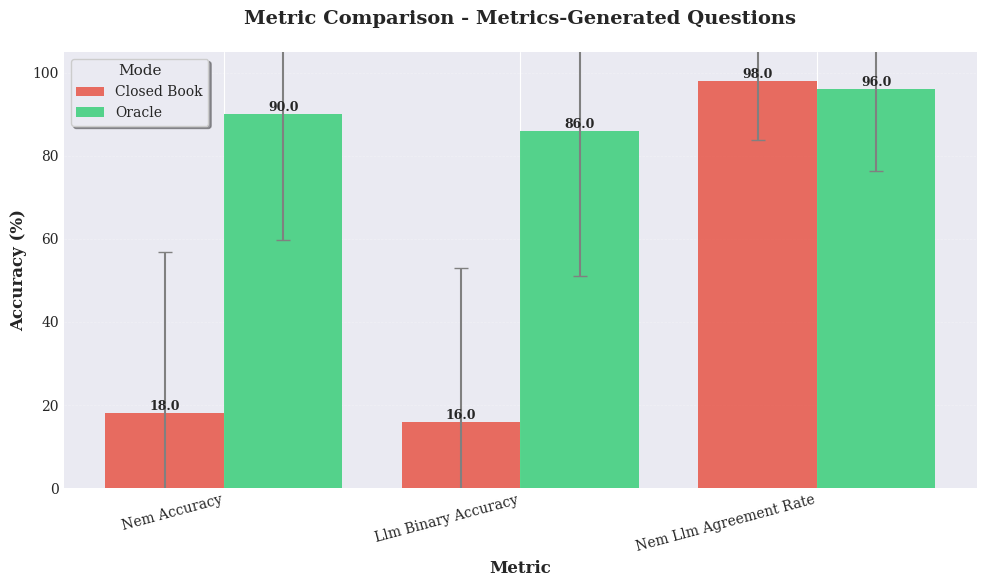

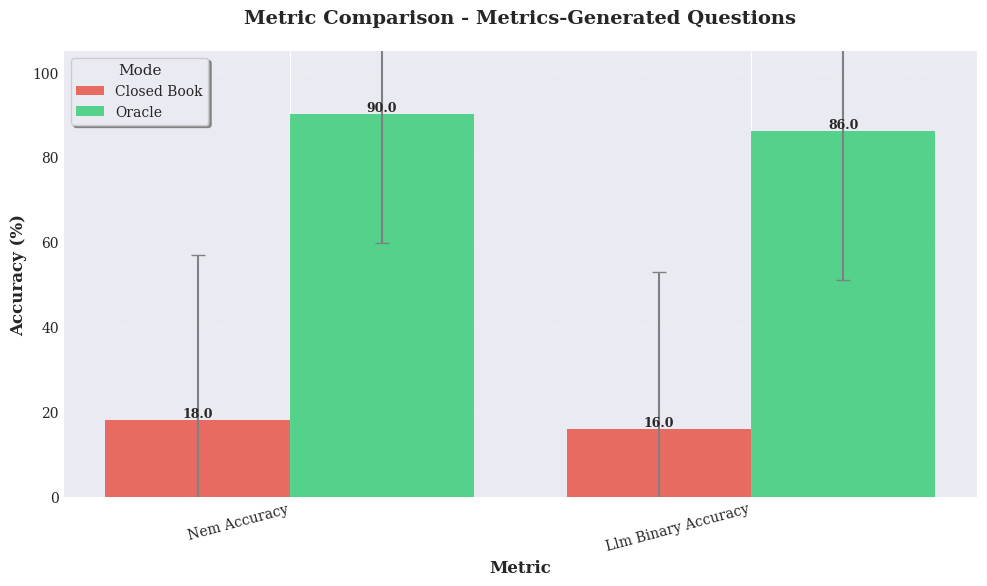

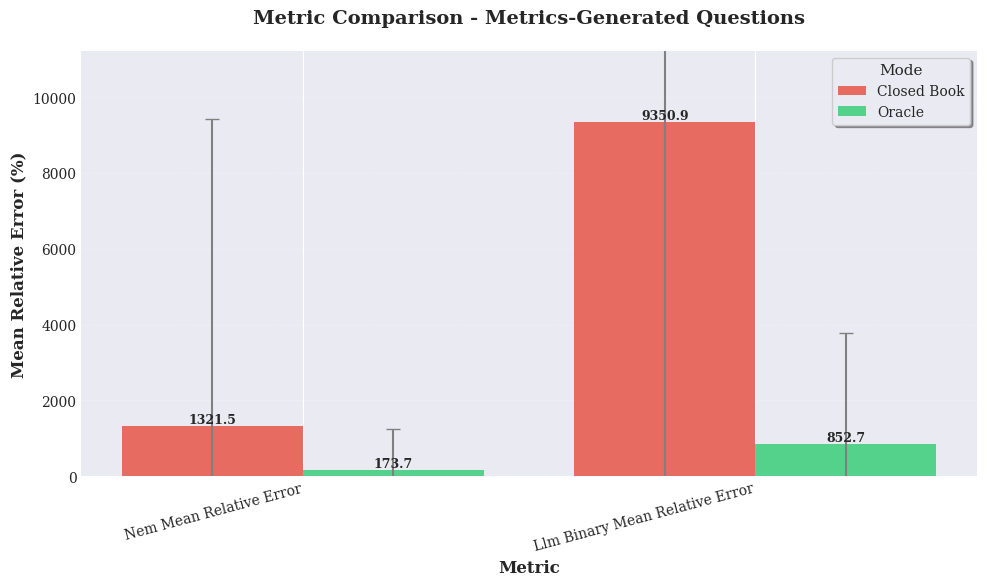

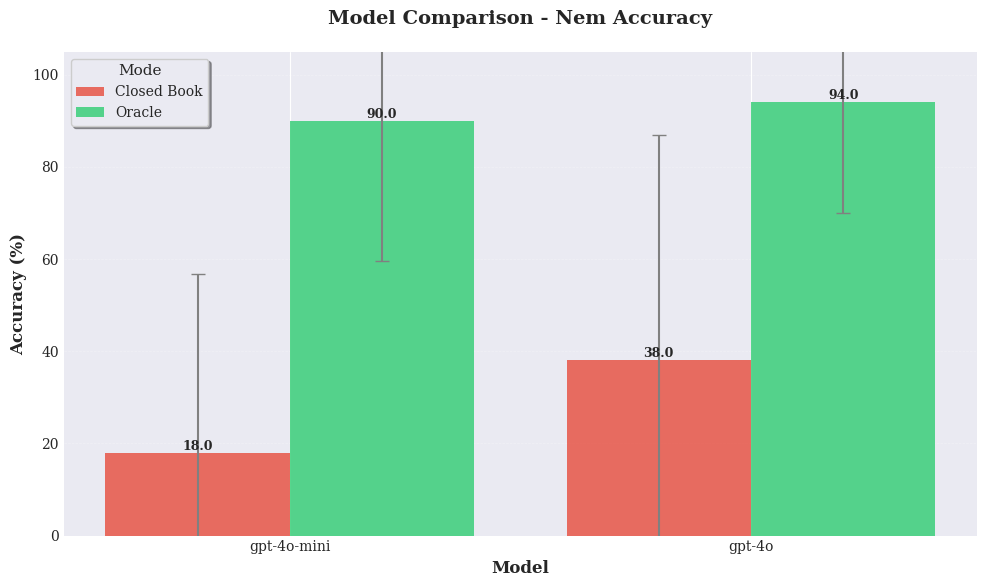

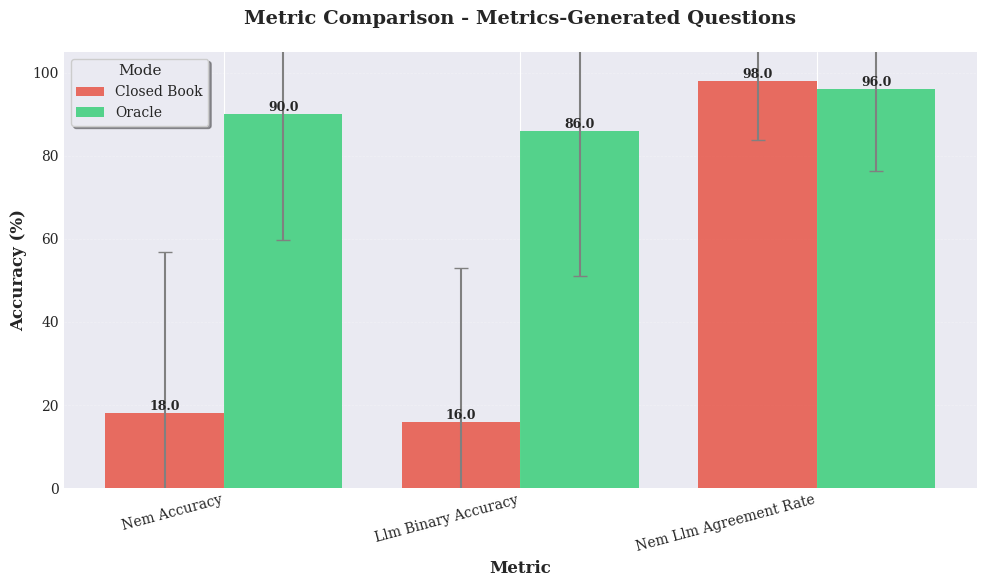

In [16]:
PLOT_PATH = "../../evaluation_results/generation/analysis/plots"

# 1. Compare NEM vs LLM-binary accuracy
plot_metric_comparison_numerical(
    df=df,
    metrics=['nem_accuracy', 'llm_binary_accuracy'],
    models=['gpt-4o-mini'],
    output_path=f'{PLOT_PATH}/nem_vs_llm.png'
)

# 2. Compare error rates
plot_metric_comparison_numerical(
    df=df,
    metrics=['nem_mean_relative_error', 'llm_binary_mean_relative_error'],
    models=['gpt-4o-mini'],
    output_path=f'{PLOT_PATH}/error_comparison.png'
)

# 3. Compare models on NEM accuracy
plot_metric_comparison_numerical(
    df=df,
    metrics=['nem_accuracy'],
    models=['gpt-4o-mini', 'gpt-4o'],
    output_path=f'{PLOT_PATH}/model_comparison.png'
)

# 4. Compare all three: accuracy + agreement
plot_metric_comparison_numerical(
    df=df,
    metrics=['nem_accuracy', 'llm_binary_accuracy', 'nem_llm_agreement_rate'],
    models=['gpt-4o-mini'],
    output_path=f'{PLOT_PATH}/full_comparison.png'
)

In [17]:
# ============================================================================
# PHASE 2 - STEP 5: Plot 3 - LLM Score Distribution
# ============================================================================

def compute_score_distribution(
    df: pd.DataFrame,
    question_type: str
) -> pd.DataFrame:
    """
    Compute LLM score distribution grouped by mode and model.
    
    Args:
        df: Filtered DataFrame (already filtered for question_type)
        question_type: 'novel-generated' or 'domain-relevant'
    
    Returns:
        DataFrame with columns: mode, model, score_0, score_1, score_2, score_3, score_4
        (values are percentages)
    """
    if 'llm_graded_score' not in df.columns:
        raise ValueError(f"Column 'llm_graded_score' not found in DataFrame")
    
    # Group by mode and model
    grouped = df.groupby(['mode', 'model'])
    
    distribution_rows = []
    
    for (mode, model), group_df in grouped:
        total = len(group_df)
        
        row = {
            'mode': mode,
            'model': model,
            'total': total
        }
        
        # Count each score (0-4)
        for score in range(5):
            count = (group_df['llm_graded_score'] == score).sum()
            percentage = (count / total) * 100 if total > 0 else 0
            row[f'score_{score}'] = percentage
            row[f'score_{score}_count'] = count
        
        distribution_rows.append(row)
    
    return pd.DataFrame(distribution_rows)


def plot_llm_score_distribution(
    df: pd.DataFrame,
    question_type: str = 'domain-relevant',
    modes: List[str] = ['closed_book', 'rag', 'oracle'],
    providers: List[str] = None,
    models: List[str] = None,
    template_aliases: List[str] = None,
    output_path: str = None,
    title: str = None,
    figsize: Tuple[int, int] = (10, 6),
    dpi: int = 300,
    plot_type: str = 'stacked',  # 'stacked' or 'grouped'
    show_percentages: bool = True
):
    """
    Plot distribution of LLM-as-judge scores (0-4).
    
    Args:
        df: Full DataFrame from load_all_evaluations()
        question_type: 'domain-relevant' or 'novel-generated'
        modes: List of modes to include
        providers: Filter by providers
        models: Filter by models
        template_aliases: Filter by templates
        output_path: Where to save plot
        title: Custom title
        figsize: Figure size in inches
        dpi: Resolution
        plot_type: 'stacked' (stacked bars) or 'grouped' (grouped bars)
        show_percentages: If True, show percentage labels on stacked bars
    
    Returns:
        matplotlib Figure object
    
    Example:
        # Stacked bar chart for domain-relevant
        plot_llm_score_distribution(
            df=df,
            question_type='domain-relevant',
            models=['gpt-4o-mini'],
            output_path='analysis/plots/domain_score_distribution.png'
        )
        
        # Grouped bar chart for novel-generated
        plot_llm_score_distribution(
            df=df,
            question_type='novel-generated',
            models=['gpt-4o-mini'],
            plot_type='grouped',
            output_path='analysis/plots/novel_score_distribution.png'
        )
        
        # Compare multiple models
        plot_llm_score_distribution(
            df=df,
            question_type='domain-relevant',
            models=['gpt-4o-mini', 'gpt-4o'],
            output_path='analysis/plots/domain_score_dist_comparison.png'
        )
    """
    # Apply plot font configuration
    plt.rcParams.update(PLOT_FONT_CONFIG)
    
    # Validate question type
    if question_type not in ['novel-generated', 'domain-relevant']:
        raise ValueError(
            f"question_type must be 'novel-generated' or 'domain-relevant', got '{question_type}'"
        )
    
    # Filter data
    filtered_df = filter_dataframe(
        df=df,
        question_type=question_type,
        modes=modes,
        providers=providers,
        models=models,
        template_aliases=template_aliases
    )
    
    if len(filtered_df) == 0:
        print("⚠️  No data after filtering. Cannot create plot.")
        return None
    
    print(f"\n📊 Creating LLM score distribution plot...")
    print(f"   Question type: {question_type}")
    print(f"   Plot type: {plot_type}")
    print(f"   Data points: {len(filtered_df)}")
    print(f"   Modes: {filtered_df['mode'].unique().tolist()}")
    print(f"   Models: {filtered_df['model'].unique().tolist()}")
    
    # Compute score distribution
    dist_df = compute_score_distribution(filtered_df, question_type)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique modes and models
    unique_modes = [m for m in modes if m in dist_df['mode'].values]
    unique_models = dist_df['model'].unique().tolist()
    
    # Define colors for scores (gradient from red to green)
    SCORE_COLORS = {
        0: '#E74C3C',  # Red (bad)
        1: '#E67E22',  # Orange
        2: '#F39C12',  # Yellow
        3: '#2ECC71',  # Light Green
        4: '#27AE60'   # Green (good)
    }
    
    SCORE_LABELS = {
        0: 'Score 0 (Wrong)',
        1: 'Score 1 (Poor)',
        2: 'Score 2 (Acceptable)',
        3: 'Score 3 (Good)',
        4: 'Score 4 (Perfect)'
    }
    
    # Determine grouping structure
    if len(unique_models) == 1:
        # Single model: group by mode only
        group_col = 'mode'
        groups = unique_modes
        group_labels = [m.replace('_', ' ').title() for m in unique_modes]
    else:
        # Multiple models: create mode_model combinations
        group_col = 'mode_model'
        dist_df['mode_model'] = dist_df['mode'] + '\n' + dist_df['model']
        groups = []
        group_labels = []
        for mode in unique_modes:
            for model in unique_models:
                groups.append(f"{mode}\n{model}")
                group_labels.append(f"{mode.replace('_', ' ').title()}\n{model}")
    
    # Set up positions
    x = np.arange(len(groups))
    
    if plot_type == 'stacked':
        # Stacked bar chart
        bottoms = np.zeros(len(groups))
        
        for score in range(5):
            values = []
            
            for group in groups:
                if len(unique_models) == 1:
                    group_data = dist_df[dist_df[group_col] == group]
                else:
                    group_data = dist_df[dist_df['mode_model'] == group]
                
                if len(group_data) > 0:
                    values.append(group_data[f'score_{score}'].iloc[0])
                else:
                    values.append(0)
            
            # Plot bars
            bars = ax.bar(
                x,
                values,
                bottom=bottoms,
                label=SCORE_LABELS[score],
                color=SCORE_COLORS[score],
                alpha=0.9,
                edgecolor='white',
                linewidth=1.5
            )
            
            # Add percentage labels if requested
            if show_percentages:
                for i, (bar, value) in enumerate(zip(bars, values)):
                    if value > 5:  # Only show if >= 5%
                        height = value
                        y_pos = bottoms[i] + height / 2
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            y_pos,
                            f'{value:.0f}%',
                            ha='center',
                            va='center',
                            fontsize=8,
                            fontweight='bold',
                            color='white'
                        )
            
            # Update bottoms for next stack
            bottoms += values
    
    else:  # grouped
        # Grouped bar chart
        bar_width = 0.15
        
        for score in range(5):
            values = []
            
            for group in groups:
                if len(unique_models) == 1:
                    group_data = dist_df[dist_df[group_col] == group]
                else:
                    group_data = dist_df[dist_df['mode_model'] == group]
                
                if len(group_data) > 0:
                    values.append(group_data[f'score_{score}'].iloc[0])
                else:
                    values.append(0)
            
            # Calculate positions
            positions = x + (score - 2) * bar_width
            
            # Plot bars
            ax.bar(
                positions,
                values,
                bar_width,
                label=SCORE_LABELS[score],
                color=SCORE_COLORS[score],
                alpha=0.9
            )
    
    # Customize plot
    ax.set_xlabel('Mode' if len(unique_models) == 1 else 'Mode / Model', fontweight='bold')
    ax.set_ylabel('Percentage of Queries (%)', fontweight='bold')
    
    # Auto-generate title
    if title is None:
        qtype_display = question_type.replace('-', ' ').title()
        title = f'LLM Score Distribution - {qtype_display}'
        if len(unique_models) == 1:
            title += f' ({unique_models[0]})'
    
    ax.set_title(title, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels)
    
    # Set y-axis
    if plot_type == 'stacked':
        ax.set_ylim(0, 100)
        ax.set_yticks(range(0, 101, 10))
    else:
        max_val = max([dist_df[f'score_{s}'].max() for s in range(5)])
        ax.set_ylim(0, max_val * 1.15)
    
    # Add grid
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add legend
    if plot_type == 'stacked':
        ax.legend(
            title='LLM Score',
            loc='upper left',
            bbox_to_anchor=(1.02, 1),
            frameon=True,
            fancybox=True,
            shadow=True
        )
    else:
        ax.legend(
            title='LLM Score',
            loc='best',
            frameon=True,
            fancybox=True,
            shadow=True,
            ncol=2 if len(groups) > 3 else 1
        )
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
        
        file_size_kb = os.path.getsize(output_path) / 1024
        print(f"\n💾 Saved plot:")
        print(f"   File: {output_path}")
        print(f"   Size: {file_size_kb:.2f} KB")
        print(f"   DPI: {dpi}")
    
    return fig


# ============================================================================
# STEP 5 Test Function
# ============================================================================

def test_step5(df: pd.DataFrame):
    """
    Test Step 5: LLM score distribution plots.
    
    Args:
        df: DataFrame from load_all_evaluations() (from Step 1)
    """
    print("\n" + "="*70)
    print("PHASE 2 - STEP 5: PLOT 3 - LLM SCORE DISTRIBUTION")
    print("="*70)
    
    # Create output directory
    output_dir = "../../evaluation_results/generation/analysis/plots"
    os.makedirs(output_dir, exist_ok=True)
    
    # Get unique models
    unique_models = df['model'].unique().tolist()
    print(f"\n📋 Models in dataset: {', '.join(unique_models)}")
    
    # Test 1: Domain-relevant - Stacked bar chart
    print("\n🧪 Test 1: Domain-Relevant Score Distribution (Stacked)")
    fig1 = plot_llm_score_distribution(
        df=df,
        question_type='domain-relevant',
        models=[unique_models[0]],
        plot_type='stacked',
        output_path=f'{output_dir}/distribution_domain_stacked.png'
    )
    if fig1:
        plt.close(fig1)
    
    # Test 2: Domain-relevant - Grouped bar chart
    print("\n🧪 Test 2: Domain-Relevant Score Distribution (Grouped)")
    fig2 = plot_llm_score_distribution(
        df=df,
        question_type='domain-relevant',
        models=[unique_models[0]],
        plot_type='grouped',
        output_path=f'{output_dir}/distribution_domain_grouped.png'
    )
    if fig2:
        plt.close(fig2)
    
    # Test 3: Novel-generated - Stacked bar chart
    print("\n🧪 Test 3: Novel-Generated Score Distribution (Stacked)")
    fig3 = plot_llm_score_distribution(
        df=df,
        question_type='novel-generated',
        models=[unique_models[0]],
        plot_type='stacked',
        output_path=f'{output_dir}/distribution_novel_stacked.png'
    )
    if fig3:
        plt.close(fig3)
    
    # Test 4: Novel-generated - Grouped bar chart
    print("\n🧪 Test 4: Novel-Generated Score Distribution (Grouped)")
    fig4 = plot_llm_score_distribution(
        df=df,
        question_type='novel-generated',
        models=[unique_models[0]],
        plot_type='grouped',
        output_path=f'{output_dir}/distribution_novel_grouped.png'
    )
    if fig4:
        plt.close(fig4)
    
    # Test 5: Multi-model comparison (if available)
    if len(unique_models) > 1:
        print("\n🧪 Test 5: Multi-Model Score Distribution Comparison")
        fig5 = plot_llm_score_distribution(
            df=df,
            question_type='domain-relevant',
            models=unique_models[:2],
            plot_type='stacked',
            output_path=f'{output_dir}/distribution_domain_model_comparison.png'
        )
        if fig5:
            plt.close(fig5)
    
    # List generated plots
    print("\n" + "="*70)
    print("📋 Generated Plot Files (Step 5):")
    print("="*70)
    
    distribution_plots = sorted([f for f in glob.glob(f"{output_dir}/distribution_*.png")])
    for plot_file in distribution_plots:
        file_size_kb = os.path.getsize(plot_file) / 1024
        filename = os.path.basename(plot_file)
        print(f"   {filename:50s} ({file_size_kb:6.2f} KB)")
    
    print("\n" + "="*70)
    print("✅ Step 5 Complete!")
    print("="*70)
    print("\nStep 5 Functions Implemented:")
    print("  ✓ compute_score_distribution(df, question_type)")
    print("  ✓ plot_llm_score_distribution(df, question_type, modes, ...)")
    print("\nFeatures:")
    print("  ✓ Two plot types: stacked and grouped")
    print("  ✓ Score distribution (0-4) visualization")
    print("  ✓ Color gradient (red to green)")
    print("  ✓ Percentage labels on stacked bars")
    print("  ✓ Support for single or multiple models")
    print("  ✓ Works for novel-generated and domain-relevant")
    print("\nPlot Files Generated:")
    print(f"  ✓ {len(distribution_plots)} distribution plots in {output_dir}/")
    print("\n" + "="*70)
    print("🎉 PHASE 2 COMPLETE - ALL VISUALIZATION STEPS DONE!")
    print("="*70)
    print("\nAll Phase 2 Steps Completed:")
    print("  ✅ Step 1: Data Loading")
    print("  ✅ Step 2: CSV Export")
    print("  ✅ Step 3: Performance by Mode Plot")
    print("  ✅ Step 4: Metric Comparison Plot")
    print("  ✅ Step 5: LLM Score Distribution Plot")
    print("\nYou now have:")
    print("  • Complete DataFrame with all evaluation data")
    print("  • CSV exports (detail + summary)")
    print("  • Flexible plotting functions for all question types")
    print("  • Publication-quality visualizations")
    print("\n" + "="*70)


# To test:
if __name__ == "__main__":
    # Load data from Step 1
    df = load_all_evaluations("../../evaluation_results/generation")
    
    # Run Step 5 tests
    test_step5(df)


LOADING EVALUATION RESULTS

📁 Path: ../../evaluation_results/generation
📊 Found 8 evaluation files

   Loading: evaluation_closed_book_domain-relevant_openai_gpt-4o-mini_0.0_domain_closed_basic.json
      Mode: closed_book
      Question Type: domain-relevant
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o-mini_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_closed_book_metrics-generated_openai_gpt-4o_0.0_metrics_closed_basic.json
      Mode: closed_book
      Question Type: metrics-generated
      Model: openai/gpt-4o
      Queries: 50

   Loading: evaluation_closed_book_novel-generated_openai_gpt-4o-mini_0.0_novel_closed_basic.json
      Mode: closed_book
      Question Type: novel-generated
      Model: openai/gpt-4o-mini
      Queries: 50

   Loading: evaluation_oracle_domain-relevant_openai_gpt


📊 Creating LLM score distribution plot...
   Question type: domain-relevant
   Plot type: stacked
   Data points: 100
   Modes: ['closed_book', 'oracle']
   Models: ['gpt-4o-mini']

💾 Saved plot:
   File: ../../evaluation_results/generation/analysis/plots/domain_dist_stacked.png
   Size: 181.55 KB
   DPI: 300

📊 Creating LLM score distribution plot...
   Question type: novel-generated
   Plot type: grouped
   Data points: 100
   Modes: ['closed_book', 'oracle']
   Models: ['gpt-4o-mini']

💾 Saved plot:
   File: ../../evaluation_results/generation/analysis/plots/novel_dist_grouped.png
   Size: 141.97 KB
   DPI: 300

📊 Creating LLM score distribution plot...
   Question type: domain-relevant
   Plot type: stacked
   Data points: 100
   Modes: ['closed_book', 'oracle']
   Models: ['gpt-4o-mini']

💾 Saved plot:
   File: ../../evaluation_results/generation/analysis/plots/model_comparison_dist.png
   Size: 181.55 KB
   DPI: 300

📊 Creating LLM score distribution plot...
   Question type: do

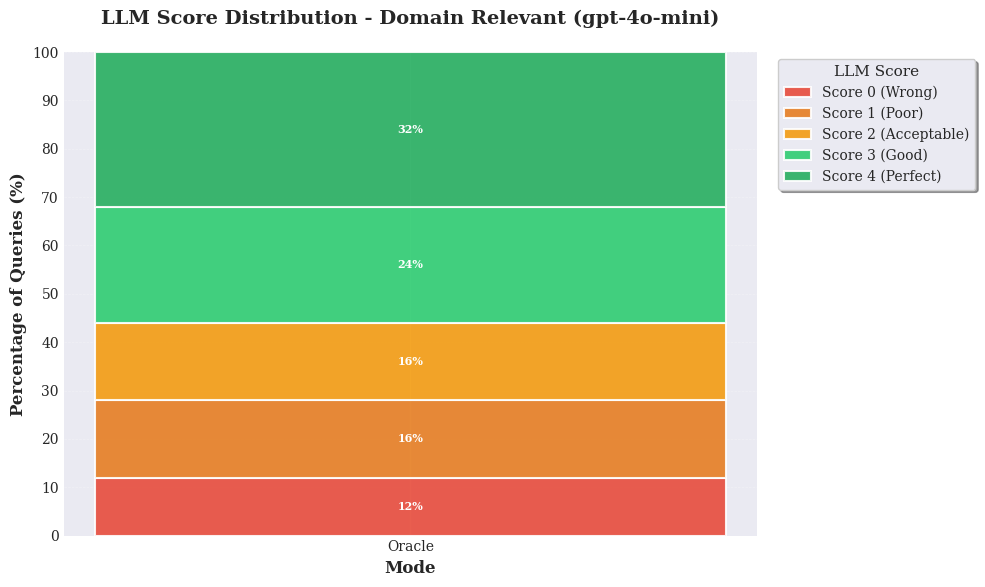

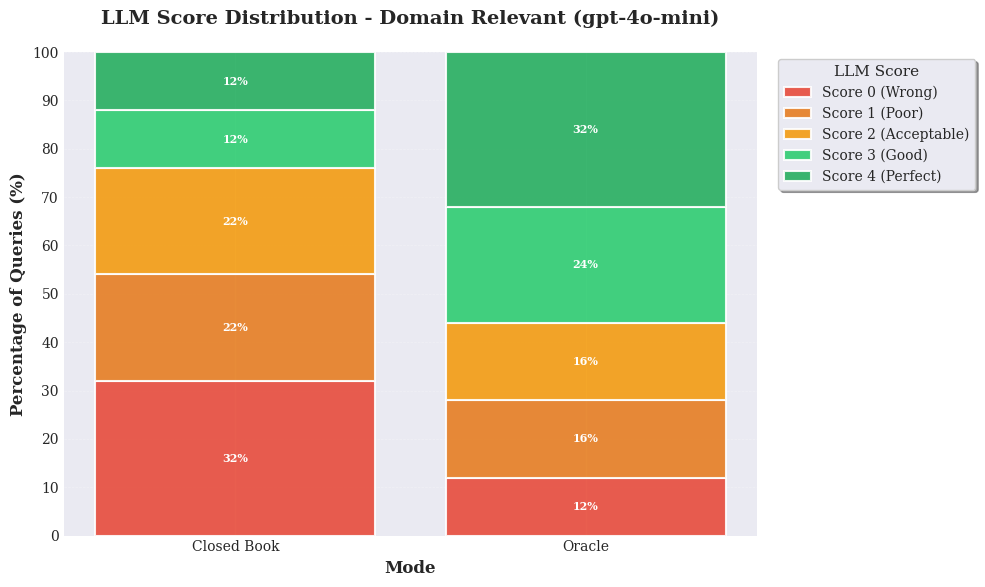

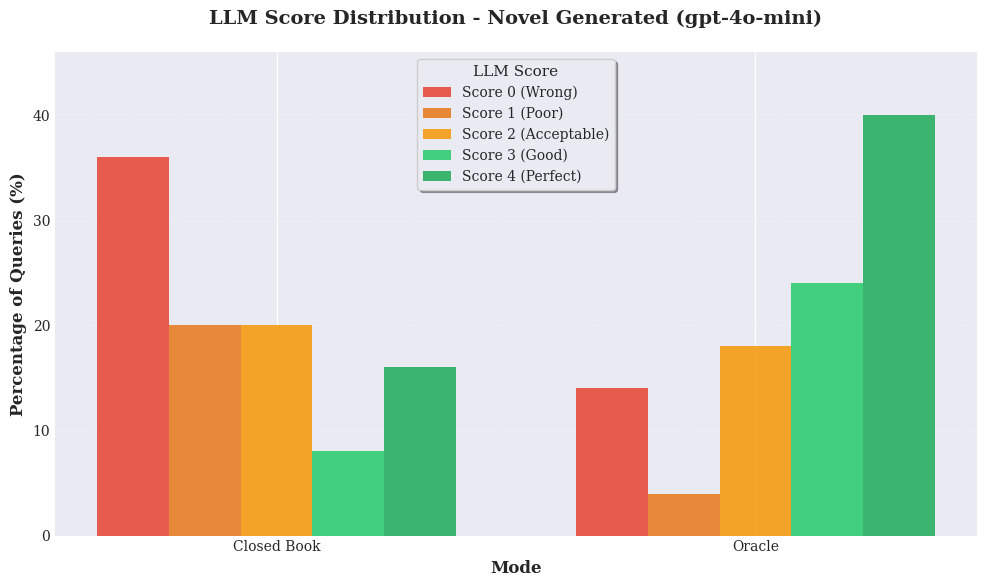

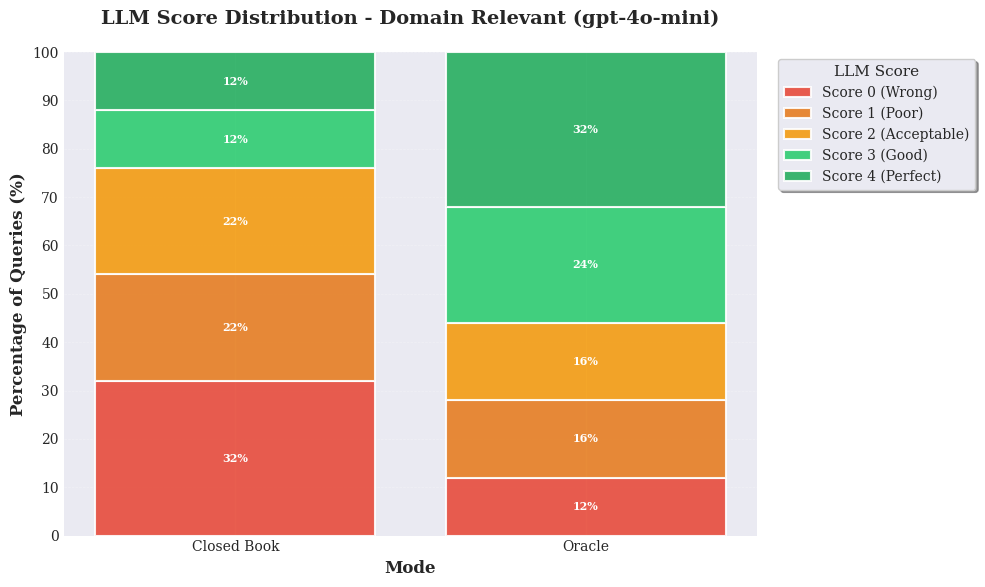

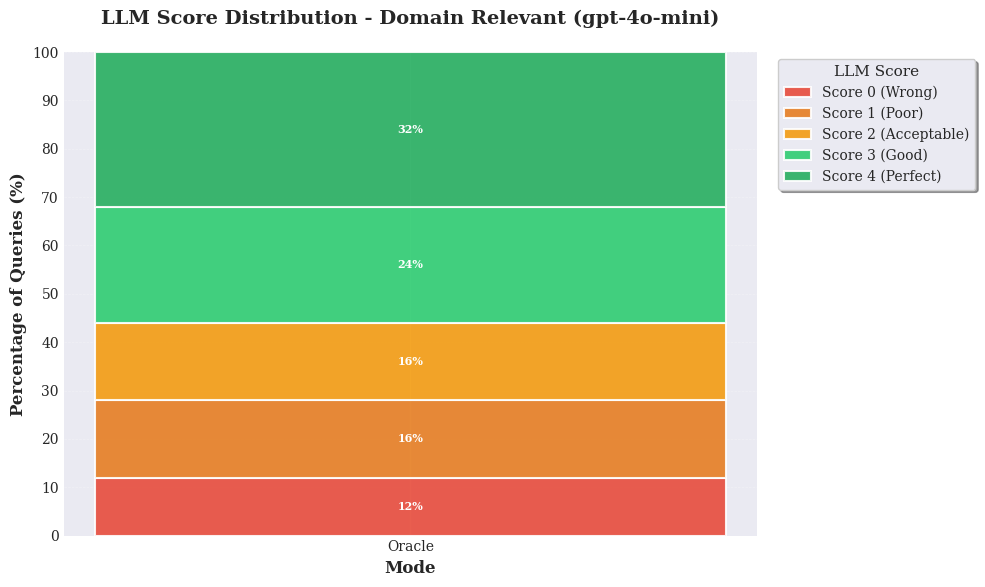

In [18]:
# 1. Stacked distribution for domain-relevant
plot_llm_score_distribution(
    df=df,
    question_type='domain-relevant',
    models=['gpt-4o-mini'],
    plot_type='stacked',
    output_path='../../evaluation_results/generation/analysis/plots/domain_dist_stacked.png'
)

# 2. Grouped distribution for better comparison
plot_llm_score_distribution(
    df=df,
    question_type='novel-generated',
    models=['gpt-4o-mini'],
    plot_type='grouped',
    output_path='../../evaluation_results/generation/analysis/plots/novel_dist_grouped.png'
)

# 3. Compare multiple models
plot_llm_score_distribution(
    df=df,
    question_type='domain-relevant',
    models=['gpt-4o-mini', 'gpt-4o'],
    plot_type='stacked',
    output_path='../../evaluation_results/generation/analysis/plots/model_comparison_dist.png'
)

# 4. Custom subset (only RAG and Oracle)
plot_llm_score_distribution(
    df=df,
    question_type='domain-relevant',
    modes=['rag', 'oracle'],
    models=['gpt-4o-mini'],
    output_path='../../evaluation_results/generation/analysis/plots/rag_oracle_dist.png'
)